#  Lending_Club - Loar_Grade_Prediction

# Description
1. For the Loan Lending club, it's extremely important to know how's the loan repayment capacity for each loan applicant, and how much interest rate should be assigned to each loan application appropriately. 
    - Firstly, knowing the loan repayment capacity for each loan applicant could help it decide whether to "accept" or "deny" a loan application. 
    - Second, evaluating interest rate precisely could bring an additional incentive for those who are willing to "lend" money and also attain a balance between demand (borrowers) and supply (lenders).
2. As a result, some suitable metrics must be determined by looking at the dataset.
    - **Metrics**
        - loan status: To evaluate the loan repayment capacity for each loan applicant.
        - grade: A good categorical index to know the loan repayment capacity.
        - interest rate: A numerical feature playing a role of balancing demand and supply. 
3. In this jupyter notebook, we bulid models to predict **'Loan_Grade'** with matric **'grade'**.

## Main Task

1. Prepare the dataset 
2. Categorical Feature Transformation
    - 2.1 One-hot encoding
    - 2.2 Dummy features
3. Data preprocessing
    - 3.1 Split data into train and test sets
    - 3.2 Standarize data
4. Modeling
    - 4.1 Logistic Regression
        - 4.1.1 RandomizedSearchCV - Logistic Regression
        - 4.1.2 Confusion Matrix - Logistic Regression
        - 4.1.3 Features' coefficients by Logistic Regression
    - 4.2 Random Forest 
        - 4.2.1 RandomizedSearchCV - Random Forest
        - 4.2.2 Confusion Matrix - Random Forest
        - 4.2.3 Feature importance by Random Forest
    - 4.3 Gradient Boosting Decision Tree
        - 4.3.1 RandomizedSearchCV - GBDT
        - 4.3.2 Confusion Matrix - GBDT
5. Summary 
    - 5.1 Feature Conclusion
    - 5.2 Model Deployment
    - 5.3 Next Step

In [54]:
# Data structure packages
import pandas as pd
import numpy as np

# Machine Learning packages
import time
import math
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from PIL import Image

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## 1. Prepare the dataset

In [55]:
# load data
loan = pd.read_csv("../data/final_LC_loan.csv")

In [56]:
# exclude target label related features
no_other_response_loan = loan.drop(['loan_status', 'loan_status_binary', 'sub_grade', 'int_rate','grade'], axis = 1)

#### exclude Loan payment related features which are unavailable when we try to predict Loan_Grade

In [57]:
pyment_related = ['installment', 'funded_amnt', 'funded_amnt_inv', 'last_pymnt_amnt', 'level_diff_last_issue_d', 
                  'level_diff_next_issue_d', 'pymnt_plan', 'total_pymnt' ,'total_pymnt_inv', 'total_rec_int', 
                'total_rec_prncp', 'out_prncp', 'out_prncp_inv']

In [58]:
# exclude target label related features
no_other_response_loan = no_other_response_loan.drop(pyment_related, axis = 1)
y = loan.grade.values

In [59]:
# One-hot encoding on y (grade)
le = LabelEncoder()
le_count = 0

le.fit(y)
y = le.transform(y)
y

array([2, 0, 1, ..., 2, 1, 2])

In [60]:
# show labels
set(y)

{0, 1, 2, 3, 4, 5, 6}

## 2. Categorical Feature Transformation
- 2.1 One-hot encoding
- 2.2 Dummy features

### 2.1 One-hot encoding

In [61]:
# check missing value
one_hot_column = []
dummy_column = []

for each in no_other_response_loan:
    if no_other_response_loan[each].dtype == 'object':
        print(each, no_other_response_loan[each].isnull().sum())
        if len(no_other_response_loan[each].unique()) <= 2:
            one_hot_column.append(each)
        elif len(no_other_response_loan[each].unique()) > 2:
            dummy_column.append(each)

term 0
emp_length 0
home_ownership 0
verification_status 0
purpose 0
title 0
initial_list_status 0
application_type 0
hardship_flag 0
hardship_type 0
hardship_reason 0
hardship_status 0
hardship_loan_status 0
disbursement_method 0
debt_settlement_flag 0
settlement_status 0
days_between_issue_payment_plan_start_date 0
days_between_issue_hardship_start_date 0
days_between_issue_hardship_end_date 0
level_between_issue_settlement_date 0
level_between_max_issue_sec_earliest_cr_line 0
level_since_last_credit_pull 0
T_unique_title 0
level_since_issue 0
level_between_max_issue_earliest_cr_line 0
group_state 0


In [62]:
# One-hot encoding for categorical variables containing two levels
le = LabelEncoder()
le_count = 0

for col in one_hot_column:
    print(col)
    le.fit(no_other_response_loan[col])
    no_other_response_loan[col] = le.transform(no_other_response_loan[col])
            
    # Keep track of how many columns were label encoded
    le_count += 1
            
print('%d columns were label encoded.' % le_count)

term
initial_list_status
application_type
hardship_flag
hardship_type
hardship_status
disbursement_method
debt_settlement_flag
settlement_status
9 columns were label encoded.


### 2.2 Dummy features

In [63]:
# Create dummy features
sum_len = 0
for col in dummy_column:
    sum_len += len(no_other_response_loan[col].unique())
    print(col, len(no_other_response_loan[col].unique()))
    
print('In total:', sum_len - len(dummy_column), 'will be additionally added.')

emp_length 12
home_ownership 4
verification_status 3
purpose 13
title 12
hardship_reason 3
hardship_loan_status 3
days_between_issue_payment_plan_start_date 3
days_between_issue_hardship_start_date 4
days_between_issue_hardship_end_date 3
level_between_issue_settlement_date 5
level_between_max_issue_sec_earliest_cr_line 11
level_since_last_credit_pull 10
T_unique_title 21
level_since_issue 3
level_between_max_issue_earliest_cr_line 10
group_state 5
In total: 108 will be additionally added.


## 3. Data preprocessing

### 3.1 Split data into train and test sets

In [64]:
# Seperate features into x (independent features) and y (dependent feature)
print(no_other_response_loan.shape)
print(y.shape)

(107864, 81)
(107864,)


In [65]:
# 81 + 108 = 189, correct dummy feature transformation!, correct dummy feature transformation!
x = pd.get_dummies(no_other_response_loan, columns = dummy_column)
print(x.shape)

(107864, 189)


In [66]:
# Split data into train and test (80% & 20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, random_state = 1)

### 3.2 Standarize data

In [67]:
# Before modeling, standardize each feature
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

In [68]:
print(x_train_std.shape)
print(x_test_std.shape)
print(len(y_train))
print(len(y_test))

(86291, 189)
(21573, 189)
86291
21573


## 4. Modeling
- 4.1 Logistic Regression
    - 4.1.1 RandomizedSearchCV - Logistic Regression
    - 4.1.2 Confusion Matrix - Logistic Regression
    - 4.1.3 Features' coefficients by Logistic Regression
- 4.2 Random Forest 
    - 4.2.1 RandomizedSearchCV - Random Forest
    - 4.2.2 Confusion Matrix - Random Forest
    - 4.2.3 Feature importance by Random Forest
- 4.3 Gradient Boosting Decision Tree
    - 4.3.1 RandomizedSearchCV - GBDT
    - 4.3.2 Confusion Matrix - GBDT

### 4.1 Logistic Regression

In [69]:
# It's a multiclassification problem
# Need to change two parameters: multi_class & solver
from sklearn.linear_model import LogisticRegression
LR_multi_clf = LogisticRegression(C=1.0, penalty='l2', multi_class='multinomial', solver='newton-cg')

In [70]:
# Define a function to compute accuracy scores for train and test datasets,
# and produce a confusion matrix on the test dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def multi_class_performance(clf, X_train, y_train, X_test, y_test):
    # Modeling fitting by the train dataset
    clf.fit(X_train, y_train)
    
    # Compute accuracy scores for train and test datasets
    accuracy_train = accuracy_score(y_train, clf.predict(X_train))
    accuracy_test = accuracy_score(y_test, clf.predict(X_test))
    
    # Produce a multi-classification confusion matrix
    LR_multi_confusion_matrix = pd.DataFrame({'True Grade A':confusion_matrix(y_test, clf.predict(X_test)).ravel()[0:7],\
                                          'True Grade B':confusion_matrix(y_test, clf.predict(X_test)).ravel()[7:14],\
                                          'True Grade C':confusion_matrix(y_test, clf.predict(X_test)).ravel()[14:21],\
                                          'True Grade D':confusion_matrix(y_test, clf.predict(X_test)).ravel()[21:28],\
                                          'True Grade E':confusion_matrix(y_test, clf.predict(X_test)).ravel()[28:35],\
                                          'True Grade F':confusion_matrix(y_test, clf.predict(X_test)).ravel()[35:42],\
                                          'True Grade G':confusion_matrix(y_test, clf.predict(X_test)).ravel()[42:49]
                                             },index = ['Predicted Grade A', 'Predicted Grade B', 'Predicted Grade C',
                                                   'Predicted Grade D', 'Predicted Grade E', 'Predicted Grade F',
                                                   'Predicted Grade G'])    
    # Final outputs
    return accuracy_train, accuracy_test, LR_multi_confusion_matrix

In [71]:
# Accuracy scores
# Train: 0.8119
# Test: 0.8074   
accuracy_train, accuracy_test, LR_multi_confusion_matrix = multi_class_performance(LR_multi_clf, x_train_std, y_train, x_test_std, y_test)
print('accuracy_train:', accuracy_train)
print('accuracy_test:', accuracy_test)

accuracy_train: 0.5419800442688113
accuracy_test: 0.5340008343763037


In [72]:
# The cells located at the diagonal line are the number of labels predicted correctly
LR_multi_confusion_matrix

,True Grade A,True Grade B,True Grade C,True Grade D,True Grade E,True Grade F,True Grade G
Predicted Grade A,4017,1209,251,50,3,0,0
Predicted Grade B,1183,3572,1832,525,35,3,0
Predicted Grade C,105,1667,3110,1703,343,57,7
Predicted Grade D,1,88,540,751,278,85,9
Predicted Grade E,0,9,29,35,69,1,0
Predicted Grade F,0,0,0,1,0,1,0
Predicted Grade G,0,0,1,1,2,0,0


In [73]:
# accuracy for D to G
accuracy_from_D_to_G = sum(LR_multi_confusion_matrix.iloc[i,i] for i in range(3,7)) / sum(sum(LR_multi_confusion_matrix.iloc[:,i] for i in range(3,7)))
print('accuracy for D to G is' , accuracy_from_D_to_G)

accuracy for D to G is 0.2073755998989644


### 4.1.1 RandomizedSearchCV - Logistic Regression

In [74]:
from sklearn.model_selection import RandomizedSearchCV

In [75]:
# Record the randomized grid searching time
start_time = time.time()

# Initiate the Logistic Regression Classifier
LR_clf = LogisticRegression()

# Construct ranges for each parameter 
param_grid = {'multi_class':['multinomial'],
              'solver':['newton-cg'],
              'penalty': ['l2'],
              'C': [i * 0.01 for i in range(1, 101, 10)],
              'tol': [1e-3,1e-4,1e-5],
              'max_iter':[100]
             }

# Due to time constraint, do the randomized grid searching 30 times 
# Find the optimal combination of parameters such that the highest accuracy score attained
grid_obj = RandomizedSearchCV(LR_clf, param_distributions=param_grid, cv=5, scoring='accuracy',
                              n_iter = 30)
grid_obj.fit(x_train_std, y_train)

print('execution time', time.time() - start_time)

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not c

execution time 16476.51667189598


In [76]:
# Call back the optimal combination of parameters 
LR_best_clf = grid_obj.best_estimator_
LR_best_clf

LogisticRegression(C=0.11, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.001, verbose=0, warm_start=False)

In [77]:
grid_search_result = pd.DataFrame({'rank': grid_obj.cv_results_['rank_test_score'].tolist(),
                                   'params': grid_obj.cv_results_['params'],
                                   'mean_test_score': grid_obj.cv_results_['mean_test_score'],
                                   'mean_train_score': grid_obj.cv_results_['mean_train_score'],
                                   'std_test_score': grid_obj.cv_results_['std_test_score'],
                                   'std_train_score': grid_obj.cv_results_['std_train_score']
                                  })

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [78]:
# Look at the 'fluctuations' among folds
# When fit the Logistic Regression with the best combination of parameters
# The standard deviation of train scores among five folds is steady: 0.001153
# The standard deviation of test scores among five folds is steady: 0.002191
grid_search_result

,rank,params,mean_test_score,mean_train_score,std_test_score,std_train_score
0,28,"{'tol': 0.001, 'solver': 'newton-cg', 'penalty...",0.535722,0.540436,0.004840,0.000908
1,28,"{'tol': 0.0001, 'solver': 'newton-cg', 'penalt...",0.535722,0.540436,0.004840,0.000908
2,28,"{'tol': 1e-05, 'solver': 'newton-cg', 'penalty...",0.535722,0.540436,0.004840,0.000908
3,1,"{'tol': 0.001, 'solver': 'newton-cg', 'penalty...",0.537321,0.541824,0.003933,0.000724
4,1,"{'tol': 0.0001, 'solver': 'newton-cg', 'penalt...",0.537321,0.541824,0.003933,0.000724
5,1,"{'tol': 1e-05, 'solver': 'newton-cg', 'penalty...",0.537321,0.541824,0.003933,0.000724
6,4,"{'tol': 0.001, 'solver': 'newton-cg', 'penalty...",0.537263,0.541980,0.003671,0.000691
7,4,"{'tol': 0.0001, 'solver': 'newton-cg', 'penalt...",0.537263,0.541980,0.003671,0.000691
8,4,"{'tol': 1e-05, 'solver': 'newton-cg', 'penalty...",0.537263,0.541980,0.003671,0.000691
9,10,"{'tol': 0.001, 'solver': 'newton-cg', 'penalty...",0.537182,0.542136,0.003717,0.000557


### 4.1.2 Confusion Matrix - Logistic Regression

In [79]:
# Accuracy scores
# Train: 0.8109
# Test: 0.8068
accuracy_train, accuracy_test, LR_multi_confusion_matrix = multi_class_performance(LR_best_clf, x_train_std, y_train, x_test_std, y_test)
print('accuracy_train:', accuracy_train)
print('accuracy_test:', accuracy_test)

accuracy_train: 0.5418178025518304
accuracy_test: 0.5342326055717795


In [80]:
# The cells located at the diagonal line are the number of labels predicted correctly
LR_multi_confusion_matrix

,True Grade A,True Grade B,True Grade C,True Grade D,True Grade E,True Grade F,True Grade G
Predicted Grade A,4022,1211,250,50,3,0,0
Predicted Grade B,1179,3570,1838,527,36,3,0
Predicted Grade C,104,1671,3117,1708,338,56,7
Predicted Grade D,1,86,528,747,283,86,9
Predicted Grade E,0,7,30,33,68,1,0
Predicted Grade F,0,0,0,1,0,1,0
Predicted Grade G,0,0,0,0,2,0,0


In [81]:
# accuracy for D to G
accuracy_from_D_to_G = sum(LR_multi_confusion_matrix.iloc[i,i] for i in range(3,7)) / sum(sum(LR_multi_confusion_matrix.iloc[:,i] for i in range(3,7)))
print('accuracy for D to G is' , accuracy_from_D_to_G)

accuracy for D to G is 0.20611265471078555


### 4.1.3 Features' coefficients by Logistic Regression

In [82]:
# Positive Direction
df_coeffs = pd.DataFrame(list(zip(x.columns, LR_best_clf.coef_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'coeff']
df_coeffs.head(10)

,feature,coeff
46,num_sats,0.841310
57,disbursement_method,0.808005
52,total_bc_limit,0.770911
50,tot_hi_cred_lim,0.737185
53,total_il_high_credit_limit,0.698108
48,pct_tl_nvr_dlq,0.632104
23,total_rev_hi_lim,0.578026
60,numeric_diff_last_issue_d,0.431750
35,mort_acc,0.382665
39,num_actv_rev_tl,0.366035


In [83]:
# Negative Direction
df_coeffs = pd.DataFrame(list(zip(x.columns, LR_best_clf.coef_.flatten()))).sort_values(by=[1], ascending=True)
df_coeffs.columns = ['feature', 'coeff']
df_coeffs.head(10)

,feature,coeff
1,term,-2.516056
3,dti,-1.048324
49,percent_bc_gt_75,-0.889699
17,total_bal_il,-0.704989
11,tot_cur_bal,-0.668035
7,revol_util,-0.620862
27,acc_open_past_24mths,-0.516830
6,revol_bal,-0.514363
5,open_acc,-0.490089
22,all_util,-0.445706


### 4.2 Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
RF_clf = RandomForestClassifier(n_estimators = 100, max_depth = 25, min_samples_leaf = 5, random_state = 0)

In [85]:
# Accuracy scores
# Train: 0.9629
# Test: 0.7346 
accuracy_train, accuracy_test, RF_multi_confusion_matrix = multi_class_performance(RF_clf, x_train_std, y_train, x_test_std, y_test)
print('accuracy_train:', accuracy_train)
print('accuracy_test:', accuracy_test)

accuracy_train: 0.9059113928451403
accuracy_test: 0.5123070504797663


In [86]:
# The cells located at the diagonal line are the number of labels predicted correctly
RF_multi_confusion_matrix

,True Grade A,True Grade B,True Grade C,True Grade D,True Grade E,True Grade F,True Grade G
Predicted Grade A,3863,1250,322,71,8,0,0
Predicted Grade B,1297,3678,2047,686,96,6,1
Predicted Grade C,146,1606,3200,1998,483,95,10
Predicted Grade D,0,11,194,311,143,46,5
Predicted Grade E,0,0,0,0,0,0,0
Predicted Grade F,0,0,0,0,0,0,0
Predicted Grade G,0,0,0,0,0,0,0


In [87]:
# accuracy for D to G
accuracy_from_D_to_G = sum(RF_multi_confusion_matrix.iloc[i,i] for i in range(3,7)) / sum(sum(RF_multi_confusion_matrix.iloc[:,i] for i in range(3,7)))
print('accuracy for D to G is' , accuracy_from_D_to_G)

accuracy for D to G is 0.07855519070472342


### 4.2.1 RandomizedSearchCV - Random Forest

In [88]:
# Record the randomized grid searching time
start_time = time.time()

# Initiate the Random Forest Classifier
RF_clf = RandomForestClassifier()

# Construct ranges for each parameter 
param_grid = {'n_estimators': [50,100,150],
              'max_features': [i for i in range(1, 51, 10)],
              'max_depth': [i for i in range(1, 21, 10)],
              'min_samples_leaf': [i for i in range(1, 51, 10)]
             }

# Do the randomized grid searching 30 times 
# Find the optimal combination of parameters such that the highest accuracy score attained
grid_obj = RandomizedSearchCV(RF_clf, param_distributions=param_grid, cv=5, scoring='accuracy',
                              n_iter = 30)
grid_obj.fit(x_train_std, y_train)

print('execution time', time.time() - start_time)

execution time 2866.1249899864197


In [89]:
# Call back the optimal combination of parameters 
RF_best_clf = grid_obj.best_estimator_
RF_best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features=41, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=21, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
grid_search_result = pd.DataFrame({'rank': grid_obj.cv_results_['rank_test_score'].tolist(),
                                   'params': grid_obj.cv_results_['params'],
                                   'mean_test_score': grid_obj.cv_results_['mean_test_score'],
                                   'mean_train_score': grid_obj.cv_results_['mean_train_score'],
                                   'std_test_score': grid_obj.cv_results_['std_test_score'],
                                   'std_train_score': grid_obj.cv_results_['std_train_score']
                                  })

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [91]:
# Look at the 'fluctuations' among folds
# When fit the Random Forest with the best combination of parameters
# The standard deviation of train scores among five folds is steady: 0.003071
# The standard deviation of test scores among five folds is steady: 0.004720
grid_search_result

,rank,params,mean_test_score,mean_train_score,std_test_score,std_train_score
0,11,"{'n_estimators': 100, 'min_samples_leaf': 41, ...",0.415153,0.416338,0.004898,0.003622
1,22,"{'n_estimators': 50, 'min_samples_leaf': 1, 'm...",0.402244,0.402026,0.006223,0.008198
2,21,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.403530,0.403915,0.003948,0.003473
3,30,"{'n_estimators': 50, 'min_samples_leaf': 21, '...",0.300576,0.300576,0.000016,0.000004
4,19,"{'n_estimators': 50, 'min_samples_leaf': 1, 'm...",0.405280,0.406187,0.005764,0.003972
5,17,"{'n_estimators': 50, 'min_samples_leaf': 11, '...",0.407134,0.407180,0.008834,0.009453
6,24,"{'n_estimators': 50, 'min_samples_leaf': 11, '...",0.361625,0.377285,0.014909,0.018665
7,2,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.515743,0.656980,0.001544,0.000350
8,29,"{'n_estimators': 100, 'min_samples_leaf': 21, ...",0.320161,0.320242,0.011471,0.011552
9,20,"{'n_estimators': 150, 'min_samples_leaf': 11, ...",0.405118,0.405488,0.005763,0.003946


### 4.2.2 Confusion Matrix - Random Forest

In [92]:
# Accuracy scores
# Train: 0.8821
# Test: 0.8448
accuracy_train, accuracy_test, RF_multi_confusion_matrix = multi_class_performance(RF_best_clf, x_train_std, y_train, x_test_std, y_test)
print('accuracy_train:', accuracy_train)
print('accuracy_test:', accuracy_test)

accuracy_train: 0.5911624619021683
accuracy_test: 0.5167107031938071


In [93]:
# The cells located at the diagonal line are the number of labels predicted correctly
RF_multi_confusion_matrix

,True Grade A,True Grade B,True Grade C,True Grade D,True Grade E,True Grade F,True Grade G
Predicted Grade A,3969,1368,387,87,10,0,0
Predicted Grade B,1252,3689,2030,717,65,4,1
Predicted Grade C,85,1479,3133,1906,493,78,12
Predicted Grade D,0,9,213,356,162,65,3
Predicted Grade E,0,0,0,0,0,0,0
Predicted Grade F,0,0,0,0,0,0,0
Predicted Grade G,0,0,0,0,0,0,0


In [94]:
# accuracy for D to G
accuracy_from_D_to_G = sum(RF_multi_confusion_matrix.iloc[i,i] for i in range(3,7)) / sum(sum(RF_multi_confusion_matrix.iloc[:,i] for i in range(3,7)))
print('accuracy for D to G is' , accuracy_from_D_to_G)

accuracy for D to G is 0.08992169739833292


### 4.2.3 Feature importance by Random Forest

In [95]:
df_coeffs = pd.DataFrame(list(zip(x.columns, RF_best_clf.feature_importances_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'importance']
df_coeffs.head(10)

,feature,importance
1,term,0.187252
29,bc_open_to_buy,0.129525
49,percent_bc_gt_75,0.057590
30,bc_util,0.044932
22,all_util,0.038524
57,disbursement_method,0.035174
7,revol_util,0.033710
52,total_bc_limit,0.032801
3,dti,0.028659
23,total_rev_hi_lim,0.025182


### 4.3 Gradient Boosting Decision Tree

In [96]:
from sklearn.ensemble import GradientBoostingClassifier

# Use a good start of parameter combination
parameters = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.7,
    'max_features':0.8,
    'random_state': 0
}

GBDT_clf = GradientBoostingClassifier(**parameters)

In [97]:
# Accuracy scores
# Train: 0.9570
# Test: 0.9330
accuracy_train, accuracy_test, GBDT_multi_confusion_matrix = multi_class_performance(GBDT_clf, x_train_std, y_train, x_test_std, y_test)
print('accuracy_train:', accuracy_train)
print('accuracy_test:', accuracy_test)

accuracy_train: 0.6253722867970009
accuracy_test: 0.5389607379594864


In [98]:
# The cells located at the diagonal line are the number of labels predicted correctly
GBDT_multi_confusion_matrix

,True Grade A,True Grade B,True Grade C,True Grade D,True Grade E,True Grade F,True Grade G
Predicted Grade A,4020,1198,264,52,4,0,0
Predicted Grade B,1180,3761,1915,571,54,3,0
Predicted Grade C,97,1471,3002,1619,337,54,7
Predicted Grade D,5,102,533,763,252,81,8
Predicted Grade E,2,8,42,51,79,5,1
Predicted Grade F,0,3,5,5,3,2,0
Predicted Grade G,2,2,2,5,1,2,0


In [99]:
# accuracy for D to G
accuracy_from_D_to_G = sum(GBDT_multi_confusion_matrix.iloc[i,i] for i in range(3,7)) / sum(sum(GBDT_multi_confusion_matrix.iloc[:,i] for i in range(3,7)))
print('accuracy for D to G is' , accuracy_from_D_to_G)

accuracy for D to G is 0.21318514776458702


### 4.3.1 RandomizedSearchCV - GBDT

In [100]:
# Record the randomized grid searching time
start_time = time.time()

# Initiate the GBDT Classifier
GBDT_clf = GradientBoostingClassifier()

# Construct ranges for each parameter 
param_grid = {'n_estimators': [50,100,150],
              'max_depth': [3,4,5,6],
              'learning_rate': [i * 0.01 for i in range(1, 101, 10)],
              'subsample': [0.8,0.9],
              'max_features': [0.8,0.9]
             }

# Do the randomized grid searching 30 times 
# Find the optimal combination of parameters such that the highest accuracy score attained
grid_obj = RandomizedSearchCV(GBDT_clf, param_distributions=param_grid, cv=5, scoring='accuracy',
                              n_iter = 30)
grid_obj.fit(x_train_std, y_train)

print('execution time', time.time() - start_time)

execution time 145429.9485771656


In [101]:
# Call back the optimal combination of parameters 
GBDT_best_clf = grid_obj.best_estimator_
GBDT_best_clf

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.11, loss='deviance', max_depth=5,
              max_features=0.9, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False)

In [102]:
grid_search_result = pd.DataFrame({'rank': grid_obj.cv_results_['rank_test_score'].tolist(),
                                   'params': grid_obj.cv_results_['params'],
                                   'mean_test_score': grid_obj.cv_results_['mean_test_score'],
                                   'mean_train_score': grid_obj.cv_results_['mean_train_score'],
                                   'std_test_score': grid_obj.cv_results_['std_test_score'],
                                   'std_train_score': grid_obj.cv_results_['std_train_score']
                                  })

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [103]:
# Look at the 'fluctuations' among folds
# When fit the GBDT with the best combination of parameters
# The standard deviation of train scores among five folds is steady: 0.013841
# The standard deviation of test scores among five folds is steady: 0.013814
grid_search_result

,rank,params,mean_test_score,mean_train_score,std_test_score,std_train_score
0,14,"{'subsample': 0.9, 'n_estimators': 150, 'max_f...",0.511803,0.938383,0.003918,0.001211
1,29,"{'subsample': 0.8, 'n_estimators': 100, 'max_f...",0.388465,0.485495,0.111309,0.163167
2,23,"{'subsample': 0.9, 'n_estimators': 100, 'max_f...",0.484013,0.492798,0.000989,0.000295
3,8,"{'subsample': 0.8, 'n_estimators': 50, 'max_fe...",0.522152,0.609342,0.006824,0.007622
4,22,"{'subsample': 0.8, 'n_estimators': 100, 'max_f...",0.484801,0.493397,0.001365,0.000861
5,27,"{'subsample': 0.9, 'n_estimators': 150, 'max_f...",0.442665,0.579617,0.030628,0.061900
6,1,"{'subsample': 0.9, 'n_estimators': 150, 'max_f...",0.542513,0.688760,0.001836,0.000963
7,21,"{'subsample': 0.9, 'n_estimators': 100, 'max_f...",0.485277,0.568704,0.014472,0.032333
8,18,"{'subsample': 0.8, 'n_estimators': 50, 'max_fe...",0.496100,0.522644,0.001677,0.000643
9,16,"{'subsample': 0.9, 'n_estimators': 100, 'max_f...",0.500296,0.547279,0.013808,0.024832


### 4.3.2 Confusion Matrix - GBDT

In [104]:
# Accuracy scores
# Train: 0.9798
# Test: 0.9485
accuracy_train, accuracy_test, GBDT_multi_confusion_matrix = multi_class_performance(GBDT_best_clf, x_train_std, y_train, x_test_std, y_test)
print('accuracy_train:', accuracy_train)
print('accuracy_test:', accuracy_test)

accuracy_train: 0.6686328817605544
accuracy_test: 0.5479071061048533


In [105]:
# The cells located at the diagonal line are the number of labels predicted correctly
GBDT_multi_confusion_matrix

,True Grade A,True Grade B,True Grade C,True Grade D,True Grade E,True Grade F,True Grade G
Predicted Grade A,4049,1139,243,48,3,0,0
Predicted Grade B,1144,3767,1835,536,55,3,0
Predicted Grade C,103,1517,3021,1529,327,44,5
Predicted Grade D,9,113,620,888,245,91,10
Predicted Grade E,0,9,38,59,93,6,0
Predicted Grade F,0,0,5,2,3,2,1
Predicted Grade G,1,0,1,4,4,1,0


In [106]:
# accuracy for D to G
accuracy_from_D_to_G = sum(GBDT_multi_confusion_matrix.iloc[i,i] for i in range(3,7)) / sum(sum(GBDT_multi_confusion_matrix.iloc[:,i] for i in range(3,7)))
print('accuracy for D to G is' , accuracy_from_D_to_G)

accuracy for D to G is 0.24829502399595857


## 5. Summary 
- 5.1. Feature Conclusion
- 5.2. Model Deployment
- 5.3 Next Step

### 5.1. Feature Conclusion
**Features' coefficients estimated by Logistic Regression:**
- Positive Direction: As long as the **funded_amnt_inv** (total amount committed by investors for that loan at that point in time), **loan_amnt** (The listed amount of the loan applied for by the borrower), and **out_prncp_inv** (Remaining outstanding principal for portion of total amount funded by investors) become larger, the higher probability that a loan applicantion might be graded with a lower grade.

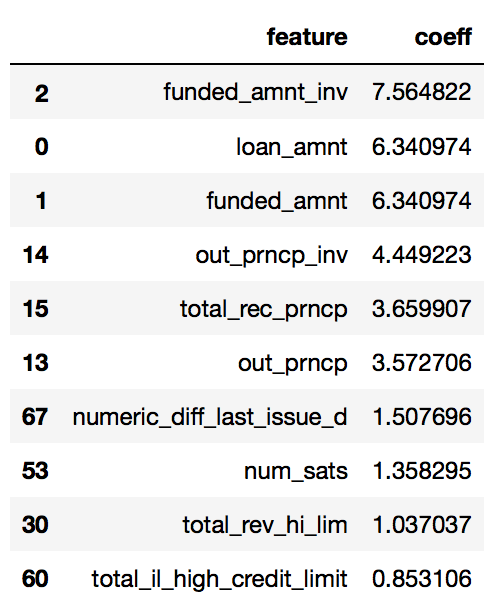

In [107]:
positive_coefficients_LR = Image.open("../image/Loan_Grade_Features_positive_coefficients_LR.png")
positive_coefficients_LR

- Negative Direction: When the **total_rec_int** (interest received to date), **installment**(The monthly payment owed by the borrower if the loan originates), and **term**(The number of payments on the loan) become smaller, the higher probability that a loan applicantion might be graded with a lower grade.

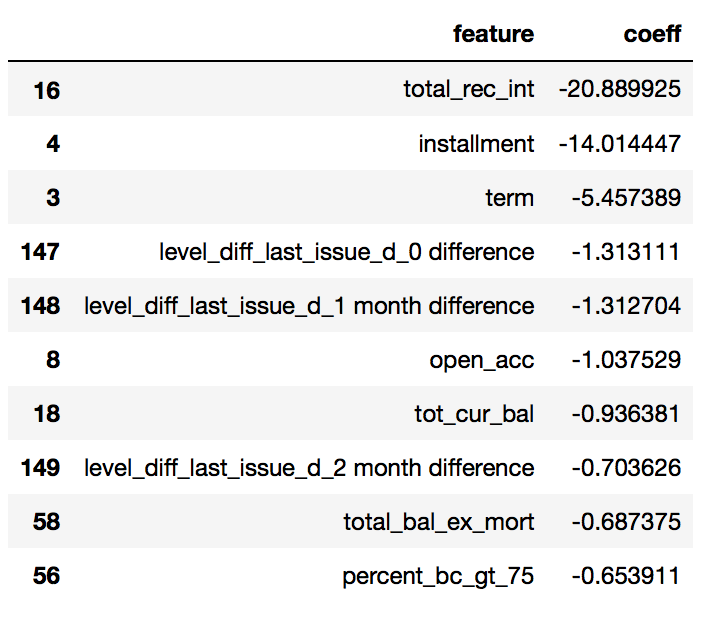

In [108]:
negative_coefficients_LR = Image.open("../image/Loan_Grade_Features_negative_coefficients_LR.png")
negative_coefficients_LR

**Features' importances by Random Forest:**
- Nine of the feature importances provided by Random Forest are overlapped with the results by Logistic Regression. These top 10 features have a better prediction power compared with the rest of the features in Random Forest model.

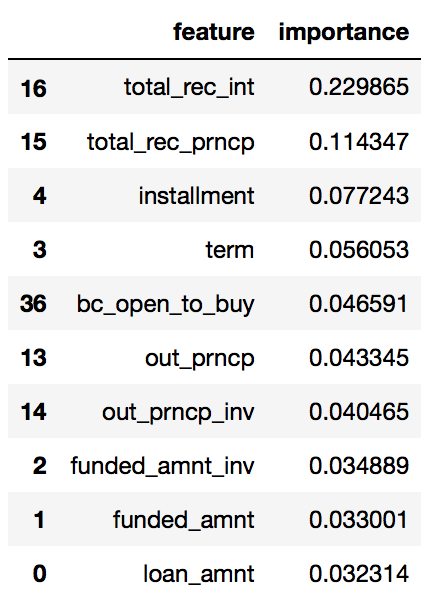

In [109]:
feature_importance_RF = Image.open("../image/Loan_Grade_Features_importance_RF.png")
feature_importance_RF


### 5.2.Model Deployment (Metric evaulations):

- For the Lending Club, it can decide a model deployment by a predefined objective. At here, my defined objective is the highest 'accuracy' score across all lables (grade A to G). However, it might be better (or more intuitive) for the Lending Club to target at the accuracy score of 'lower grades' (such as from grade D to G). Thus, **GB Regression** is preferred here.


| Model | Accuracy | Accuracy (from grade D to G) |
| ---  | --- | --- |
| Logistic Regression | 0.5342 | 0.2061|
| Random Forest | 0.5167 | 0.0899 |
| GBDT | **0.5479** | **0.2483** |

### 5.3 Next Step

The predictive power of our models is week here(Accuracy is low, especially in lower grade prediction), this might because that Lending Club decide the loan grade based more on set of qualitative norms or quantitative data that are not in our dataset. 

To build better models, we should spend more time to understand Lending Club's business model and loan grade decision making process to get more related and complete dataset.